In [0]:
from zipfile import ZipFile
with ZipFile('/content/data-20190801T152116Z-001.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('data')

In [0]:
from pandas import read_hdf
df_final_train = read_hdf('/content/data/data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/data/data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [0]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd 
import datetime
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os

import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle

### 1.Adding another feature called Preferential Attachment with followers and followees data of vertex. you can check about Preferential Attachment in below link http://be.amazd.com/link-prediction/ 

In [30]:
nf_s=np.array(df_final_train['num_followers_s'])
nf_d=np.array(df_final_train['num_followers_d'])
pre_f=[]
for i in range(len(nf_s)):
    pre_f.append(nf_d[i]*nf_s[i])
df_final_train['prefer_Attach_followers']= pre_f
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_u_dot,svd_v_dot,num_followers_d
0,848424,784690,1,0,0.0,0.029161,0.000000,14,6,9,1,0,0.000000,1,1,2,0.258199,0.377964,0.636163,0.097590,0.894362,1.014128,6.557971e-07,0.000002,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,-9.987979e-12,2.283676e-13,1.439968e-10,6.136162e-13,4.188171e-13,5.983361e-15,-1.026186e-11,5.316372e-13,5.843225e-10,1.166047e-13,2.253356e-11,3.220367e-15,-2.148852e-13,1.883148e-13,5.904807e-11,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,8.425267e-20,2.074808e-17,0
1,483294,1255532,1,0,0.0,0.000000,0.000000,17,1,19,0,0,0.000000,1,1,7,0.235702,0.707107,0.942809,0.166667,1.178511,1.649916,2.172064e-07,0.000001,0.000739,0.000801,1.702625e-19,2.706300e-15,2.522357e-16,5.277458e-15,-2.079151e-15,7.009864e-16,6.970710e-10,9.561769e-15,1.728794e-15,3.122935e-18,-1.960277e-11,2.861530e-11,1.939773e-08,1.907382e-12,3.797410e-11,4.992848e-14,-4.054309e-13,2.895682e-13,2.545382e-10,2.248568e-14,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,1.352160e-17,1.188376e-17,0
2,626190,1729265,1,0,0.0,0.000000,0.000000,10,16,9,0,0,0.000000,0,1,5,0.301511,0.242536,0.544047,0.073127,0.845558,0.786583,1.853369e-06,0.000002,0.000789,0.000770,9.426796e-14,4.116616e-16,2.253244e-15,2.079387e-15,-1.782290e-11,2.389627e-11,1.443050e-06,2.358030e-12,2.689638e-12,1.739178e-12,-1.863934e-13,1.806783e-13,2.544597e-07,1.693295e-13,2.712748e-13,7.594641e-15,-4.148103e-13,4.618813e-12,1.122150e-05,1.778927e-12,2.740535e-13,4.199834e-14,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,3.671980e-13,3.904885e-12,0
3,947219,425228,1,0,0.0,0.000000,0.000000,37,10,34,0,0,0.000000,0,1,3,0.162221,0.301511,0.463733,0.048912,0.625954,0.765244,7.000791e-07,0.000002,0.000778,0.000884,9.876114e-14,1.039593e-13,1.511694e-14,3.478438e-14,-4.491246e-11,9.917404e-13,7.891250e-06,9.458624e-12,2.715848e-11,1.822074e-12,-1.070733e-10,2.888035e-12,2.070703e-05,7.229355e-12,3.563659e-11,1.917977e-12,-8.942488e-12,5.535630e-12,5.223676e-06,7.917166e-13,4.020707e-12,2.817657e-13,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13,1.634044e-10,9.819784e-11,0
4,991374,975044,1,0,0.2,0.042767,0.347833,27,15,27,4,7,6.136433,0,1,2,0.188982,0.250000,0.438982,0.047246,0.627964,0.688982,7.103008e-07,0.000001,0.000779,0.000840,1.557332e-15,1.096037e-14,5.180869e-15,1.296135e-14,-9.778448e-13,5.724610e-13,4.951883e-06,1.396834e-12,2.153249e-11,2.873183e-14,-2.275780e-11,1.007615e-12,2.517628e-06,1.394103e-10,2.961969e-11,2.022115e-13,-3.804979e-12,1.593011e-13,1.035016e-06,1.361574e-13,1.154623e-12,9.656662e-14,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13,1.246700e-11,1.300892e-11,0


In [31]:
nf_s=np.array(df_final_test['num_followers_s'])
nf_d=np.array(df_final_test['num_followers_d'])
pre_f=[]
for i in range(len(nf_s)):
    pre_f.append(nf_d[i]*nf_s[i])
df_final_test['prefer_Attach_followers']= pre_f
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_u_dot,svd_v_dot,num_followers_d,prefer_Attach_followers
0,848424,784690,1,0,0.0,0.029161,0.000000,14,6,9,1,0,0.000000,1,1,2,0.258199,0.377964,0.636163,0.097590,0.894362,1.014128,6.557971e-07,0.000002,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,-9.987979e-12,2.283676e-13,1.439968e-10,6.136162e-13,4.188171e-13,5.983361e-15,-1.026186e-11,5.316372e-13,5.843225e-10,1.166047e-13,2.253356e-11,3.220367e-15,-2.148852e-13,1.883148e-13,5.904807e-11,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,8.425267e-20,2.074808e-17,0,0
1,483294,1255532,1,0,0.0,0.000000,0.000000,17,1,19,0,0,0.000000,1,1,7,0.235702,0.707107,0.942809,0.166667,1.178511,1.649916,2.172064e-07,0.000001,0.000739,0.000801,1.702625e-19,2.706300e-15,2.522357e-16,5.277458e-15,-2.079151e-15,7.009864e-16,6.970710e-10,9.561769e-15,1.728794e-15,3.122935e-18,-1.960277e-11,2.861530e-11,1.939773e-08,1.907382e-12,3.797410e-11,4.992848e-14,-4.054309e-13,2.895682e-13,2.545382e-10,2.248568e-14,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,1.352160e-17,1.188376e-17,0,0
2,626190,1729265,1,0,0.0,0.000000,0.000000,10,16,9,0,0,0.000000,0,1,5,0.301511,0.242536,0.544047,0.073127,0.845558,0.786583,1.853369e-06,0.000002,0.000789,0.000770,9.426796e-14,4.116616e-16,2.253244e-15,2.079387e-15,-1.782290e-11,2.389627e-11,1.443050e-06,2.358030e-12,2.689638e-12,1.739178e-12,-1.863934e-13,1.806783e-13,2.544597e-07,1.693295e-13,2.712748e-13,7.594641e-15,-4.148103e-13,4.618813e-12,1.122150e-05,1.778927e-12,2.740535e-13,4.199834e-14,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,3.671980e-13,3.904885e-12,0,0
3,947219,425228,1,0,0.0,0.000000,0.000000,37,10,34,0,0,0.000000,0,1,3,0.162221,0.301511,0.463733,0.048912,0.625954,0.765244,7.000791e-07,0.000002,0.000778,0.000884,9.876114e-14,1.039593e-13,1.511694e-14,3.478438e-14,-4.491246e-11,9.917404e-13,7.891250e-06,9.458624e-12,2.715848e-11,1.822074e-12,-1.070733e-10,2.888035e-12,2.070703e-05,7.229355e-12,3.563659e-11,1.917977e-12,-8.942488e-12,5.535630e-12,5.223676e-06,7.917166e-13,4.020707e-12,2.817657e-13,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13,1.634044e-10,9.819784e-11,0,0
4,991374,975044,1,0,0.2,0.042767,0.347833,27,15,27,4,7,6.136433,0,1,2,0.188982,0.250000,0.438982,0.047246,0.627964,0.688982,7.103008e-07,0.000001,0.000779,0.000840,1.557332e-15,1.096037e-14,5.180869e-15,1.296135e-14,-9.778448e-13,5.724610e-13,4.951883e-06,1.396834e-12,2.153249e-11,2.873183e-14,-2.275780e-11,1.007615e-12,2.517628e-06,1.394103e-10,2.961969e-11,2.022115e-13,-3.804979e-12,1.593011e-13,1.035016e-06,1.361574e-13,1.154623e-12,9.656662e-14,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13,1.246700e-11,1.300892e-11,0,0


FOR TRAIN DATA

In [32]:
nf_s=np.array(df_final_train['num_followees_s'])
nf_d=np.array(df_final_train['num_followees_d'])
pre_f=[]
for i in range(len(nf_s)):
    pre_f.append(nf_d[i]*nf_s[i])
df_final_train['prefer_Attach_followees']= pre_f
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_u_dot,svd_v_dot,num_followers_d,prefer_Attach_followers,prefer_Attach_followees
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666226e-13,4.613397e-13,1.043044e-05,6.676960e-13,2.451081e-13,3.584580e-12,-2.038017e-11,5.397495e-13,1.068946e-06,1.192357e-12,2.279485e-12,3.580837e-12,-7.216133e-13,3.925975e-13,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,1.114958e-11,2.238775e-12,0,0,120
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,0,1,2,0.102598,0.127000,0.229598,0.013030,0.332196,0.356598,2.353458e-07,6.427660e-07,0.000845,0.001317,3.906648e-11,9.424102e-11,1.208074e-11,1.273080e-10,7.051088e-13,-8.250564e-11,-1.717702e-10,3.705016e-02,1.032392e-11,7.207497e-10,1.644399e-12,-2.047752e-10,-3.943936e-10,8.617541e-02,2.399540e-11,1.738682e-09,2.685878e-13,-3.316849e-11,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,3.192812e-03,9.068719e-04,0,0,8662
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,26,17,10.991826,0,1,2,0.185695,0.154303,0.339999,0.028653,0.525694,0.494302,6.211019e-07,5.179801e-07,0.000885,0.000855,7.730764e-114,4.067322e-114,2.681298e-113,2.199205e-113,-4.900734e-18,1.096831e-18,-6.816555e-19,-2.226453e-18,6.710556e-19,-8.161336e-19,-2.606312e-18,6.392474e-19,-4.245830e-19,-1.315747e-18,3.849627e-19,-1.131971e-18,-1.510265e-18,1.454979e-19,-2.380564e-19,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,1.787503e-35,2.467873e-36,0,0,902
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,0,0,0.000000,0,1,6,0.288675,0.408248,0.696923,0.117851,0.985599,1.105172,2.998153e-07,1.704245e-06,0.000739,0.000773,5.443738e-17,4.139999e-16,2.413250e-14,6.688064e-15,-9.965436e-12,4.077137e-13,5.083778e-10,1.985267e-14,2.471968e-12,1.004354e-15,-2.629029e-13,1.428940e-11,9.146784e-11,8.590132e-12,2.406658e-10,7.638106e-15,-2.170899e-13,5.206150e-13,6.058498e-11,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,4.710376e-20,3.159386e-18,0,0,35
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,0,0,0.000000,0,0,-1,1.000000,0.301511,1.301511,0.301511,2.301511,1.603023,4.349180e-07,2.089590e-07,0.000751,0.000735,3.887821e-16,4.721269e-16,7.552255e-16,2.734009e-18,-3.408943e-13,1.125207e-13,3.190883e-07,8.550846e-14,1.405351e-13,7.172313e-15,-2.550169e-13,2.424636e-13,2.436301e-07,3.679960e-14,1.348520e-13,8.710393e-15,-4.795514e-13,1.521297e-13,1.197283e-07,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.773952e-14,0.000000e+00,0,0,33


FOR TEST DATA

In [33]:
nf_s=np.array(df_final_test['num_followees_s'])
nf_d=np.array(df_final_test['num_followees_d'])
pre_f=[]
for i in range(len(nf_s)):
    pre_f.append(nf_d[i]*nf_s[i])
df_final_test['prefer_Attach_followees']= pre_f
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_u_dot,svd_v_dot,num_followers_d,prefer_Attach_followers,prefer_Attach_followees
0,848424,784690,1,0,0.0,0.029161,0.000000,14,6,9,1,0,0.000000,1,1,2,0.258199,0.377964,0.636163,0.097590,0.894362,1.014128,6.557971e-07,0.000002,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,-9.987979e-12,2.283676e-13,1.439968e-10,6.136162e-13,4.188171e-13,5.983361e-15,-1.026186e-11,5.316372e-13,5.843225e-10,1.166047e-13,2.253356e-11,3.220367e-15,-2.148852e-13,1.883148e-13,5.904807e-11,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,8.425267e-20,2.074808e-17,0,0,54
1,483294,1255532,1,0,0.0,0.000000,0.000000,17,1,19,0,0,0.000000,1,1,7,0.235702,0.707107,0.942809,0.166667,1.178511,1.649916,2.172064e-07,0.000001,0.000739,0.000801,1.702625e-19,2.706300e-15,2.522357e-16,5.277458e-15,-2.079151e-15,7.009864e-16,6.970710e-10,9.561769e-15,1.728794e-15,3.122935e-18,-1.960277e-11,2.861530e-11,1.939773e-08,1.907382e-12,3.797410e-11,4.992848e-14,-4.054309e-13,2.895682e-13,2.545382e-10,2.248568e-14,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,1.352160e-17,1.188376e-17,0,0,19
2,626190,1729265,1,0,0.0,0.000000,0.000000,10,16,9,0,0,0.000000,0,1,5,0.301511,0.242536,0.544047,0.073127,0.845558,0.786583,1.853369e-06,0.000002,0.000789,0.000770,9.426796e-14,4.116616e-16,2.253244e-15,2.079387e-15,-1.782290e-11,2.389627e-11,1.443050e-06,2.358030e-12,2.689638e-12,1.739178e-12,-1.863934e-13,1.806783e-13,2.544597e-07,1.693295e-13,2.712748e-13,7.594641e-15,-4.148103e-13,4.618813e-12,1.122150e-05,1.778927e-12,2.740535e-13,4.199834e-14,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,3.671980e-13,3.904885e-12,0,0,144
3,947219,425228,1,0,0.0,0.000000,0.000000,37,10,34,0,0,0.000000,0,1,3,0.162221,0.301511,0.463733,0.048912,0.625954,0.765244,7.000791e-07,0.000002,0.000778,0.000884,9.876114e-14,1.039593e-13,1.511694e-14,3.478438e-14,-4.491246e-11,9.917404e-13,7.891250e-06,9.458624e-12,2.715848e-11,1.822074e-12,-1.070733e-10,2.888035e-12,2.070703e-05,7.229355e-12,3.563659e-11,1.917977e-12,-8.942488e-12,5.535630e-12,5.223676e-06,7.917166e-13,4.020707e-12,2.817657e-13,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13,1.634044e-10,9.819784e-11,0,0,340
4,991374,975044,1,0,0.2,0.042767,0.347833,27,15,27,4,7,6.136433,0,1,2,0.188982,0.250000,0.438982,0.047246,0.627964,0.688982,7.103008e-07,0.000001,0.000779,0.000840,1.557332e-15,1.096037e-14,5.180869e-15,1.296135e-14,-9.778448e-13,5.724610e-13,4.951883e-06,1.396834e-12,2.153249e-11,2.873183e-14,-2.275780e-11,1.007615e-12,2.517628e-06,1.394103e-10,2.961969e-11,2.022115e-13,-3.804979e-12,1.593011e-13,1.035016e-06,1.361574e-13,1.154623e-12,9.656662e-14,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13,1.246700e-11,1.300892e-11,0,0,405


### 2.Adding another feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features. you can read about this in below pdf https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf

FOR TRAIN DATA

In [0]:
a=np.array(df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']])
b=np.array(df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']])
c=np.array(df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]])
d=np.array(df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']])


In [0]:
svd_dot=[]
count=0
for i in range(len(a)):
    count=count+1
    svd_dot.append(np.dot(a[i],b[i]))

df_final_train['svd_u_dot']=svd_dot

In [0]:
svd_dot=[]
count=0
for i in range(len(c)):
    count=count+1
    svd_dot.append(np.dot(c[i],d[i]))

df_final_train['svd_v_dot']=svd_dot

In [0]:
df_final_train=df_final_train.drop(['svd_dot'],axis=1)

FOR TEST DATA

In [0]:
a=np.array(df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']])
b=np.array(df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']])
c=np.array(df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]])
d=np.array(df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']])


In [0]:
svd_dot=[]
count=0
for i in range(len(a)):
    count=count+1
    svd_dot.append(np.dot(a[i],b[i]))

df_final_test['svd_u_dot']=svd_dot



In [0]:
svd_dot=[]
count=0
for i in range(len(c)):
    count=count+1
    svd_dot.append(np.dot(c[i],d[i]))

df_final_test['svd_v_dot']=svd_dot



## MODELING

In [0]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime 
import time 

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os

import xgboost as xgb

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform


import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [0]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [0]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [37]:

import xgboost as xgb
clf = xgb.XGBClassifier()
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15)
              }
model = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1',random_state=25)


model.fit(df_final_train,y_train)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=5, n_jobs=None,
                   param_distri

In [38]:
print(model.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=None, n_estimators=123, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [0]:
clf=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=None, n_estimators=123, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [40]:
clf.fit(df_final_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=None, n_estimators=123, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [42]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9999400563470339
Test f1 score 0.9271523178807948


In [0]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


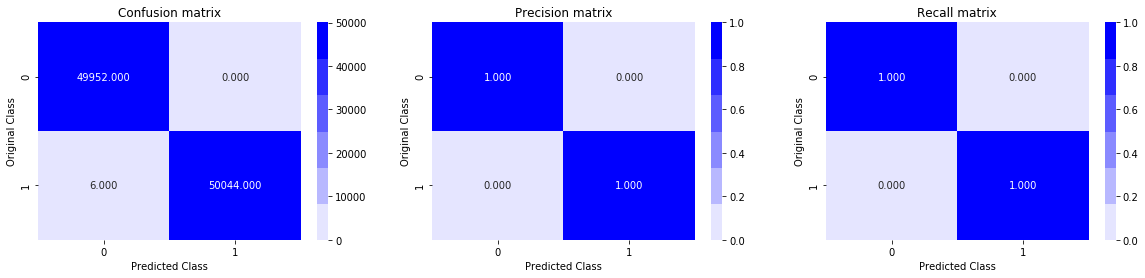

Test confusion_matrix


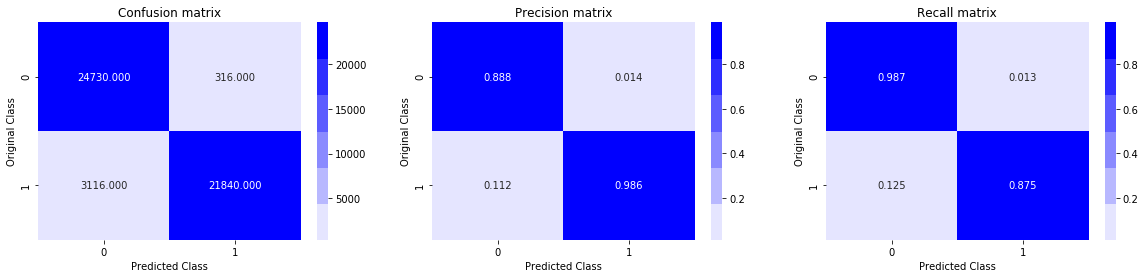

In [44]:
from sklearn.metrics import confusion_matrix
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

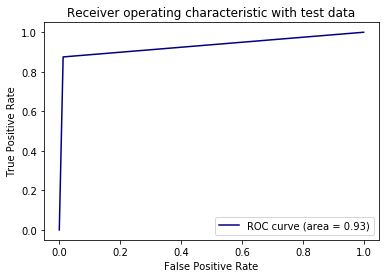

In [45]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

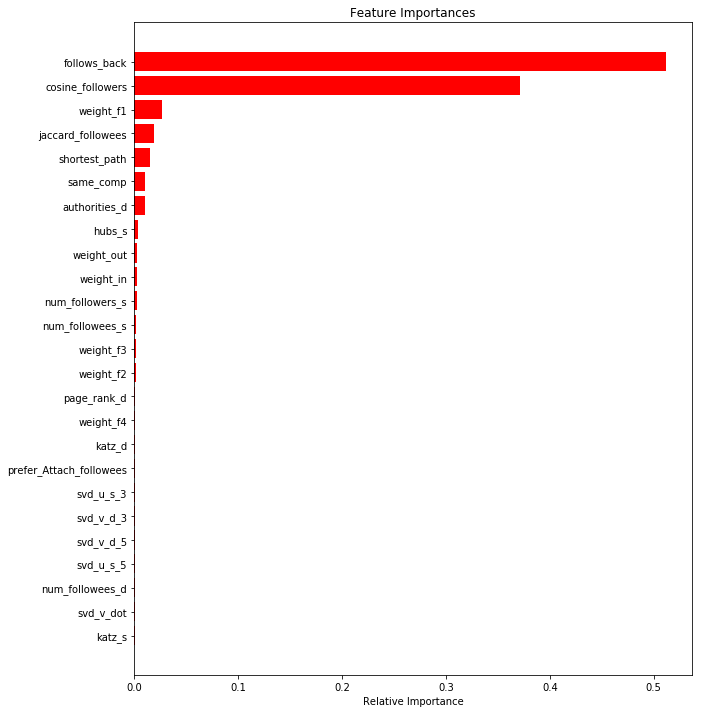

In [46]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## CONCLUSION

In [47]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", "n_estimators", "max_depth", "Train f1-Score","Test f1-Score"]
x.add_row(['XGBOOST','123','14','0.999','0.9271'])
print(x)

+---------+--------------+-----------+----------------+---------------+
|  Model  | n_estimators | max_depth | Train f1-Score | Test f1-Score |
+---------+--------------+-----------+----------------+---------------+
| XGBOOST |     123      |     14    |     0.999      |     0.9271    |
+---------+--------------+-----------+----------------+---------------+
